In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
import math
import pickle

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
x_train = train_images.reshape((60000, 784))
x_test = test_images.reshape((10000, 784))

In [4]:
x_train = x_train / 255.0
x_test  = x_test / 255.0

In [5]:
train_labels = tf.keras.utils.to_categorical(train_labels, dtype ="uint8")
test_labels = tf.keras.utils.to_categorical(test_labels, dtype ="uint8")

In [6]:
x_train.shape

(60000, 784)

In [7]:
train_labels.shape

(60000, 10)

In [8]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters 

In [9]:
def softmax(Z):
    """Computes softmax function.

    z: array of input values.

    Returns an array of outputs with the same shape as z."""
    # For numerical stability: make the maximum of z's to be 0.
    cache = Z
    shiftz = Z - np.max(Z)
    exps = np.exp(shiftz)
    A = exps / np.sum(exps)
    return A,cache

def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

In [10]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    #print("Shapes",Z.shape, A.shape, W.shape, b.shape )
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [11]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    if activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
        
    elif activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
   
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [12]:
def compute_cost_CE(AL, Y):
    """
    Implement the cost function
    Arguments:
    AL -- probability vector corresponding to your label predictions, (number of classes,batch_size)
    Y -- true "label" vector (number of classes, batch_size)

    Returns:
    cost -- cross-entropy cost
    """
    
#     print("shape of y_hat",AL.shape )
#     print("shape of y",Y.shape )
    
    m = AL.shape[1]
    # Compute loss from aL and y.
    cost = (1./m) * np.sum((-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T)))
#     print("Cost shape: ", cost.shape)

    
    cost = np.squeeze(cost)# To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
#     print(cost)
    assert(cost.shape == ())
    
    return cost

def compute_cost_categorical_CE(AL, Y):
    """
    Implement the cost function
    Arguments:
    AL -- probability vector corresponding to your label predictions, (number of classes,batch_size)
    Y -- true "label" vector (number of classes, batch_size)

    Returns:
    cost -- Categorical_cross-entropy cost
    """
    
#     print("shape of y_hat",AL.shape )
#     print("shape of y",Y.shape )
    
    m = AL.shape[1]
    # Compute loss from aL and y.
    cost = - (1./m) * np.sum(np.multiply(Y,np.log(AL)))
#     print("Cost shape: ", cost.shape)

    
    cost = np.squeeze(cost)# To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
#     print(cost)
    assert(cost.shape == ())
    
    return cost

In [13]:
# Softmax_backward wont handle the batch as of now
def softmax_backward(dA, cache):
    """Computes the gradient of the softmax function.

    z: (T, 1) array of input values where the gradient is computed. T is the
       number of output classes.

    Returns D (T, T) the Jacobian matrix of softmax(z) at the given z. D[i, j]
    is DjSi - the partial derivative of Si w.r.t. input j.
    """
    z = cache
    Sz, _ = softmax(z)
#     print("DA Shape ", dA.shape)
#     print("Sz Shape ", Sz.shape)
    
    # -SjSi can be computed using an outer product between Sz and itself. Then
    # we add back Si for the i=j cases by adding a diagonal matrix with the
    # values of Si on its diagonal.
   
    D = -np.outer(Sz, Sz) + np.diag(Sz.flatten())
    return D.dot(dA)

def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    
    print(dA.shape,Z.shape)
    assert (dZ.shape == Z.shape)
    
    return dZ

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [14]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
        
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [15]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "softmax")
    caches.append(cache)
    
    assert(AL.shape == (10,X.shape[1]))
            
    return AL, caches

In [16]:
X= x_train.T
Y=train_labels.T
learning_rate = 0.0075
num_iterations = 100
print_cost=False

cost = 0

np.random.seed(1)
grads = {}
costs = []                              # to keep track of the cost
m = X.shape[1]                           # number of examples
(n_x, n_h, n_y) = (784,20,10)
costs_batch = []                             # to keep track of the cost
costs_iterations = []
grads['dW1'] = 0
grads['db1'] = 0
grads['dW2'] = 0
grads['db2'] = 0
iteration = 0

# Initialize parameters dictionary, by calling one of the functions you'd previously implemented
### START CODE HERE ### (≈ 1 line of code)
parameters = initialize_parameters(n_x, n_h, n_y)
### END CODE HERE ###

# Get W1, b1, W2 and b2 from the dictionary parameters.
W1 = parameters["W1"]
b1 = parameters["b1"]
W2 = parameters["W2"]
b2 = parameters["b2"]

CACHE1 = []
CACHE2 = []
A1STORE = []
A2STORE = []
dA1STORE = []
dA2STORE = []
# Loop (gradient descent)

temp = []

In [17]:
import sys
myint = 12
print(sys.getsizeof(msg))

NameError: name 'msg' is not defined

In [23]:
import time
import socket
import struct

HOST = "10.6.1.155" #ip address
device_id = 9001 #port Number

def send_data(device_id,msg):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((HOST, device_id))
        s.sendall(msg)
        
def recive_data(device_id):
    print(f"{device_id} read to recive data")
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind((HOST, device_id))
        s.listen()
        conn, addr = s.accept()
        with conn:
            print(f"Connected by {addr} \n")
            while True:
                data = conn.recv(1024)
                print(data)
                if not data:
                    break
    print(f'recived data at {device_id} \n')
    
    return data

In [24]:
A, cache = linear_activation_forward(np.reshape(X[:,0], (784,1)), W1, b1, activation="relu")
layer_data = { 'A' : A,
               'cache' : cache }
device_message = {"Source":"edge_1","target":"edge_2","type":"forward","Data": layer_data }
msg = pickle.dumps(device_message)

In [25]:
first_devices = True 
send_to_devices = 9002
if __name__ =="__main__":
    if first_devices:
        time.sleep(2)
        send_data(send_to_devices,msg)
    else:
        recive_data(device_id)

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [26]:
def two_layer_model_pipeline(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 100, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector , of shape (10, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    cost = 0
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    costs_batch = []                             # to keep track of the cost
    costs_iterations = []
    grads['dW1'] = 0
    grads['db1'] = 0
    grads['dW2'] = 0
    grads['db2'] = 0
    iteration = 0
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    CACHE1 = []
    CACHE2 = []
    A1STORE = []
    A2STORE = []
    dA1STORE = []
    dA2STORE = []
    # Loop (gradient descent)
    
    temp = []
    for k in range(num_iterations):
        temp = temp + list(np.random.permutation(60000).astype(int)) 
    
    
    for tstep in range(num_iterations*60000):
        

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(np.reshape(X[:,temp[tstep]], (784,1)), W1, b1, activation="relu")
        CACHE1 =  CACHE1 + [cache1] 
        A1STORE = A1STORE + [A1]

        if(tstep>=1):
            A2, cache2 = linear_activation_forward(A1STORE[0], W2, b2, activation="softmax")
            CACHE2 = CACHE2 + [cache2] 
            A2STORE = A2STORE + [A2]
            A1STORE.pop(0)
            ### END CODE HERE ###

            # Compute cost
            ### START CODE HERE ### (≈ 1 line of code)
            cost = compute_cost_categorical_CE(A2, np.reshape(Y[:,temp[tstep-1]], (10,1)))
            ### END CODE HERE ###

        if(tstep >= 2):
            # Initializing backward propagation

            dA2 = - (np.divide(np.reshape(Y[:,temp[tstep-2]], (10,1)), A2STORE[0]))
            A2STORE.pop(0)
            dA2STORE = dA2STORE + [dA2]

        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        if(tstep >= 3):    
            dA1, dW2, db2 = linear_activation_backward(dA2STORE[0], CACHE2[0], activation="softmax")
            CACHE2.pop(0)
            dA2STORE.pop(0)
            dA1STORE = dA1STORE + [dA1]
            grads['dW2'] += dW2
            grads['db2'] += db2
            if(np.mod(tstep-3, 32)==0):
                W2 += -learning_rate*grads['dW2']/32
                parameters["W2"] = W2
                grads['dW2'] = 0
                b2 += -learning_rate*grads['db2']/32
                parameters["b2"] = b2
                grads['db2'] = 0
                
        if(tstep >= 4):    
            dA0, dW1, db1 = linear_activation_backward(dA1STORE[0], CACHE1[0], activation="relu")
            CACHE1.pop(0)
            dA1STORE.pop(0)
            grads['dW1'] += dW1
            grads['db1'] += db1
            if(np.mod(tstep-4, 32)==0):
                W1 += -learning_rate*grads['dW1']/32
                parameters["W1"] = W1
                grads['dW1'] = 0
                b1 += -learning_rate*grads['db1']/32
                parameters["b1"] = b1
                grads['db1'] = 0
           
        
        ### END CODE HERE ###

#         # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
#         grads['dW1'] += dW1
#         grads['db1'] += db1
#         grads['dW2'] += dW2
#         grads['db2'] += db2

        if np.mod(tstep,32) == 0:
            costs_batch.append(cost)
#             print("Cost batch {}: {}".format(int(tstep/32), np.squeeze(cost)))

            costs.append(cost)
        

#             # Update parameters.
#             ### START CODE HERE ### (approx. 1 line of code)
#             parameters = update_parameters(parameters, grads, learning_rate/32)
#             ### END CODE HERE ###

#             # Retrieve W1, b1, W2, b2 from parameters
#             W1 = parameters["W1"]
#             b1 = parameters["b1"]
#             W2 = parameters["W2"]
#             b2 = parameters["b2"]

#             grads['dW1'] = 0
#             grads['db1'] = 0
#             grads['dW2'] = 0
#             grads['db2'] = 0


          
        if(np.mod(tstep, 60000)==0):
            iteration = iteration + 1
            c = sum(costs_batch)/len(costs_batch)


            print("Cost iteration {}: {}".format(iteration, np.squeeze(c)))
            costs_iterations.append(c)

    # plot the cost

    plt.plot(np.squeeze(costs_iterations))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    
    return parameters

Cost iteration 1: 0.0
Cost iteration 2: 1.7959510246293837
Cost iteration 3: 1.1995981466348278
Cost iteration 4: 0.9466391631174537
Cost iteration 5: 0.8061243604714116
Cost iteration 6: 0.7166006035756952
Cost iteration 7: 0.6467870534759859
Cost iteration 8: 0.5960476340371696
Cost iteration 9: 0.5550971894624664
Cost iteration 10: 0.5279431333294721


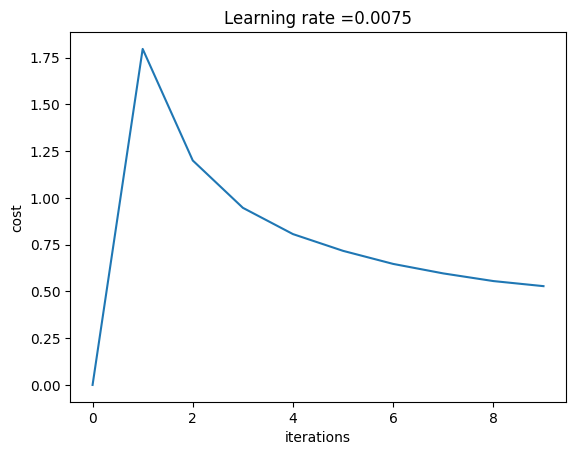

In [27]:
parameters_two_layer_model = two_layer_model_pipeline(x_train.T, train_labels.T, layers_dims = (n_x, n_h, n_y), num_iterations = 10, print_cost=True)

In [29]:
predict(x_train.T, train_labels.T, parameters_two_layer_model)

NameError: name 'predict' is not defined

In [30]:
predict(x_test.T, test_labels.T, parameters_two_layer_model)

NameError: name 'predict' is not defined